# Calculate mutual ranks and call modules of co-expressed genes
## Jen Wisecaver
#### 2019-09-23
This Bash jupyter notebook is a tutorial for 
1. Preparing a gene-level expression matrix 
2. Calculating pairwise Pearson's correlation coefficients (PCCs) and transforming PCCs to mutual ranks (MRs)
3. Identify co-expressed gene modules

$$e^{(-MR-1) \over 5}\geqslant 0.01$$

## Step 1: Create expression matrices 
This step uses R to prepare a gene-level expression matrix based on transcript-level abundance estimates output from Kallisto. There are several input files to prepare for this step. I strongly recommend going through the [transform counts jupyter notebook tutorial](https://github.rcac.purdue.edu/jwisecav/coexp-pipe/blob/master/tutorial/transform_counts.ipynb) BEFORE running `transform_counts.r`, because it walks you through preparing these input files and describes the different normalization/transformation sub-steps that are being performed under the hood. 

Here, we will use the example input files provided in the `tutorial/example` directory 

In [2]:
ls example

abundance_dir	     sample_conditions.txt
abundance_files.txt  transcripts2genes.txt


Purdue uses environment modules, so I first need to load R.

In [3]:
module load r

You can execute `transform_counts.r` without any command line arguments to print a usage guide

In [4]:
Rscript ../scripts/transform_counts.r 

Usage: ../scripts/transform_counts.r [-[-help|h]] [-[-abundances|a] <character>] [-[-lookup|l] <character>] [-[-samples|s] <character>] [-[-seqtype|t] <character>] [-[-out|o] <character>]
    -h|--help          
    -a|--abundances    Enter list of abundance estimates from Kallisto (see jupyter notebook tutorial)
    -l|--lookup        Enter transcript to gene lookup file (see jupyter notebook tutorial)
    -s|--samples       Enter experimental design file (see jupyter notebook tutorial)
    -t|--seqtype       Full-length or 3 prime tagged RNAseq? Enter [Full/full/F/f or Tag/tag/T/t]
    -o|--out           Enter base name for all output files


: 1

Pass `transform_counts.r` the necessary input files. Reference the [transform counts jupyter notebook tutorial](https://github.rcac.purdue.edu/jwisecav/coexp-pipe/blob/master/tutorial/transform_counts.ipynb) for more information about this step.

In [5]:
Rscript ../scripts/transform_counts.r -a example/abundance_files.txt -l example/transcripts2genes.txt -s example/sample_conditions.txt -t tag -o example/gene_counts

Read 10 items
[1] "tximport options: type = kallisto, tx2gene = tx2gene, countsFromAbundance =  no"
Note: importing `abundance.h5` is typically faster than `abundance.tsv`
reading in files with read.delim (install 'readr' package for speed up)
1 2 3 4 5 6 7 8 9 10 
summarizing abundance
summarizing counts
summarizing length
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, 

In [6]:
ls example

abundance_dir				       gene_counts_statistics.txt
abundance_files.txt			       sample_conditions.txt
gene_counts_normalized.matrix		       transcripts2genes.txt
gene_counts_normalized_vst_transformed.matrix


The `transform_counts.r` script returned three files:
* __\*_normalized.matrix__ contains the gene counts matrix, normalized for sample library size
* __\*_normalized_vst_transformed.matrix__ contains the variance-stabilized gene counts matrix, normalized for sample library size
* __\*_statistics.txt__ contains information helpful for identifying genes with very low expression or variance. Your dataset (the type and number of conditions), will determine how stringent you need to be when deciding which of these low expression/variance genes to exclude from the co-expression network.

## Step 2: Calculate PCC and MR
This step uses python to calculate the Pearson's correlation coefficient (PCC) for every gene pair in a gene counts matrix file and uses these PCCs to calculate the mutual rank (MR) between gene pairs. 

The MR for two example genes A and B is given by the formula:

$$MR_{AB} = \sqrt{Rank_{AinB} \times Rank_{BinA}}$$


where $Rank_{AinB}$ is the rank of gene A in a PCC-ordered list of gene B against all other genes in the matrix; similarly, $Rank_{BinA}$ is the rank of gene B in a PCC-ordered list of gene A against all other genes. Smaller MR scores indicating stronger co-expression between gene pairs. See [Obayashi et al. (2017)](https://academic.oup.com/pcp/article/59/1/e3/4690683) for more information on MR and its statistical properties. 

Execute the python script without command line arguments to print a usage description

In [7]:
python ../scripts/calc_mr_pcc.py


  Usage: ../scripts/calc_mr_pcc.py -i <input.matrix> -o <output directory> [-t <threads> -k <skipfile>]
    -i|--infile  <FILENAME>  INFILE: path to input file: matrix of gene counts
    -o|--outdir  <DIRECTORY> OUTDIR: path to output directory

    OPTIONAL:
    -t|--threads <INTEGER>   THREADS: multithreaded using os.fork (default = 1)
    -k|--skip    <FILENAME>  SKIPFILE: path to file containing list of gene to skip




: 2

The size of the input matrix will determine the runtime and amount of memory required. I haven't fully tested it to see how it scales, but an input matrix of 35,000 genes ran in 5.5 hours (using --threads 23) and required approximately 60 gigs of memory. 

In [8]:
time python ../scripts/calc_mr_pcc.py -i example/gene_counts_normalized.matrix -o example/gene_counts_normalized_mr -t 20


COMMAND: ../scripts/calc_mr_pcc.py -i example/gene_counts_normalized.matrix -o example/gene_counts_normalized_mr -t 20 

Creating output directory: /tmp/COEXP1569417385.1429212 ...

Creating output directory: example/gene_counts_normalized_mr ...

Reading in gene expression values from example/gene_counts_normalized.matrix ...

Skipping 0 genes...

Creating gene lookup tables...

Calculating PCCs...
  thread 1 : Calculating PCCs for 193 genes...
  thread 2 : Calculating PCCs for 193 genes...
  thread 3 : Calculating PCCs for 193 genes...
  thread 4 : Calculating PCCs for 193 genes...
  thread 5 : Calculating PCCs for 193 genes...
  thread 6 : Calculating PCCs for 193 genes...
  thread 7 : Calculating PCCs for 193 genes...
  thread 8 : Calculating PCCs for 193 genes...
  thread 9 : Calculating PCCs for 193 genes...
  thread 10 : Calculating PCCs for 193 genes...
  thread 11 : Calculating PCCs for 193 genes...
  thread 12 : Calculating PCCs for 193 genes...
  thread 13 : Calculating PCC

In the above example, we used --threads 20 to parallelize the PCC calculation and file I/O. The rank and MR calculations are not parallelized at this point. Given the example input matrix of 3842 genes, the runtime is less than 4 minutes. 

Let's take a look at the output. Inside the `gene_counts_normalized_mr` output directory, each gene gets its own file. Each gene file contains the PCC and MR for that gene against every other gene in the analysis (3841 genes in this example).

In [9]:
wc -l example/gene_counts_normalized_mr/g0001

3841 example/gene_counts_normalized_mr/g0001


In [10]:
head example/gene_counts_normalized_mr/g0001

g1272	1.0	0.933
g2381	2.449	0.894
g3449	2.449	0.903
g3468	2.828	0.918
g3596	2.828	0.897
g0549	3.162	0.896
g1498	7.483	0.85
g1090	8.367	0.879
g0717	8.485	0.842
g2992	12.961	0.827


Columns are ordered: \[gene2, MR, PCC\]. Rows are ordered by ascending MR scores. In the example above, gene g0001 is most correlated to g1271, with a MR = 1 and PCC = 0.933.

## Step 3: Call co-expressed gene modules
This step uses python to parse the `gene_counts_normalized_mr` output directory to create a network .abc file (tab delimited flat file with three columns: \[node1, node2, edge weight\]). In gene co-expression networks, genes are represented by nodes, and the strength of the co-expression between two genes is indicated by the edge weight. 

First, we need to apply some threshold. A network containing an edge between every gene in the analysis (even gene pairs with PCCs ≤ 0) would be needlessly complicated. So we need to decide what MR scores we consider biologically informative. 

But now, we have a slight complication, because MRs range for 1 to n-1 (where n is the number of genes in the analysis), but most network programs need edge weights that range from 0 to 1. An MR transformation is required, and an exponential decay function (see `MRtransformation.png` below) is the ideal solution. By imposing an edge weight cutoff of ≥ 0.01 and varying the decay denominator, we can vary the number of edges (ie gene correlations) retained in our network.

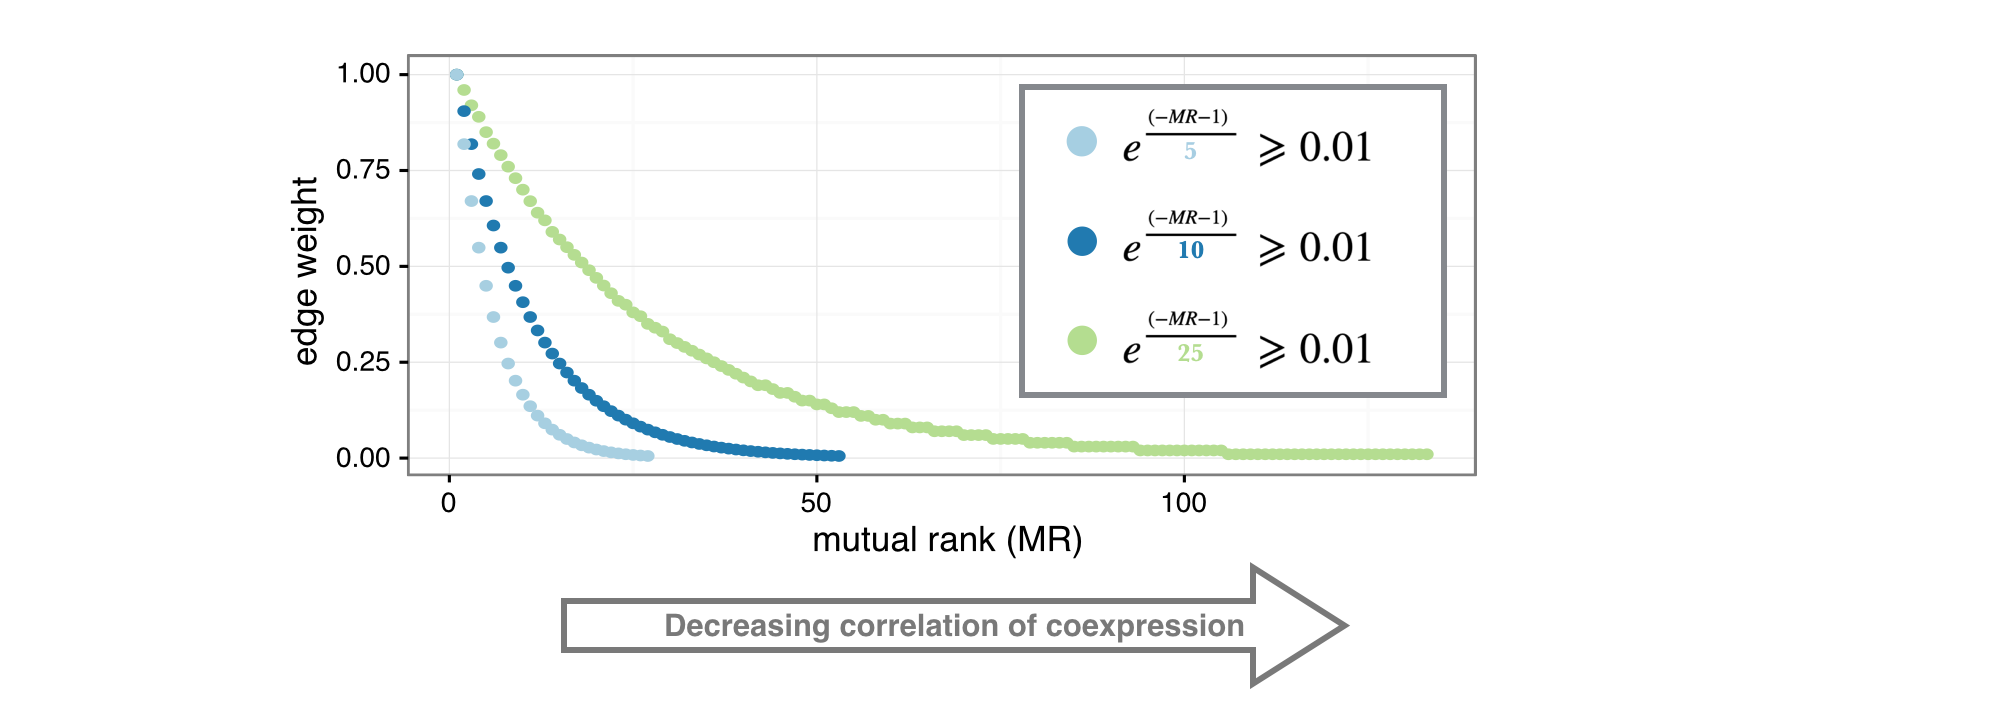

In [1]:
display < MRtransformation.png 

Notice how using 5 as the decay constant creates the fastest rate of decay (light blue curve); MR scores ≤ approx 27 are included as edge weights. Using 25 as the decay constant creates the slowest rate of decay (light green curve); MR scores ≤ approx 130 are included. Using 10 as the decay constant puts you somewhere in between (dark blue curve). 

Different rates of decay result in different average module sizes. Fast rate of decay = small modules; Slow rate of decay = large modules. This makes different decays better for different metabolic pathways. If your pathway of interest consists of fewer genes, a faster rate of decay may work better for you, because the modules will be smaller and may contain less false positives. If your pathway of interest consists of more genes, or if you want to recover a large list of gene candidates, a slower rate of decay may work better for you, because the modules will be larger. 

That's why I recomment creating several networks with different rates of decay and comparing the results. We will do this now using the `create_network_and_modules.py` python script. This script calls the [ClusterONE](https://www.paccanarolab.org/cluster-one/) program by [Nepusz et al (2012)](https://www.nature.com/articles/nmeth.1938) to create modules of co-expressed genes, and parses the output into a tab deliminted file. 

Let's execute the script without command line arguements to print a usage description:

In [12]:
python ../scripts/create_network_and_modules.py


Usage: ../scripts/create_network_and_modules.py -i <mr directory> -c <cluster one jar> -d <decay> [-o <output base name> -w <min edge weight> -p <max pvalue> -q <min quality>
    -i|--indir       <DIRECTORY> path to directory of gene mutual ranks
    -c|--clusterone  <FILE> path to clusterone jar file
    -d|--decay       <INTEGER> decay constant to use for calculating network edge weights

    OPTIONAL:
    -o|--out         <NAME> base name for all output files (default = same as input directory
    -w|--minweight   <FLOAT> minimum network edge weight (default = 0.01)
    -p|--maxpval     <FLOAT> retained modules must have p value less than or equal to this value (default = 1 to retain all modules)
    -q|--minqual     <FLOAT> retained modules must have weight greater than or equal to this value (default = 0 to retain all modules)


: 2

There are many optional command line arguments here. You can change the default edge weight cutoff from 0.01. You can also set minimum quality scores and p values for ClusterONE modules. 

Let's run the script with default settings, using 5 as our decay constant. 

In [13]:
python ../scripts/create_network_and_modules.py -i example/gene_counts_normalized_mr -c ../scripts/cluster_one-1.0.jar -d 5


COMMAND: ../scripts/create_network_and_modules.py -i example/gene_counts_normalized_mr -c ../scripts/cluster_one-1.0.jar -d 5 

Writing network abc file to example/gene_counts_normalized_mr_005.abc
Writing clusterone csv file to example/gene_counts_normalized_mr_005.modules.csv
Writing parsed clusterone tab-delimited file to example/gene_counts_normalized_mr_005.modules.txt

Parsing example/gene_counts_normalized_mr ...
	finished!


Running clusterone:
 java -jar ../scripts/cluster_one-1.0.jar example/gene_counts_normalized_mr_005.abc --output-format csv > example/gene_counts_normalized_mr_005.modules.csv 

Loaded graph with 3842 nodes and 76764 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 489 complexes

Parsing example/gene_counts_normalized_mr_005.modules.csv ...
	finished!



We can take a peak at the first line of the tab delimited output:

In [14]:
head -n 1 example/gene_counts_normalized_mr_005.modules.txt

N005M00001	0.5577	0.00000	g0052 g0197 g0203 g0231 g0518 g0605 g0653 g0791 g0928 g0930 g0945 g0959 g0967 g1043 g1127 g1164 g1168 g1236 g1274 g1457 g1530 g2938 g2981 g3217 g3220 g3322 g3341 g3530 g3613 g3638 g3780 g3855 g3861 g3985 g4090 g4256 g4278 g4411 g4471 g4521 g4586 g4858 g4893 g0140 g0853 g1083 g1089 g1266 g2583 g2651 g3253 g4520 g4522


Columns are ordered by \[module ID, module quality, module p-value, list of genes in module\]. Module IDs always start with the network decay constant. 

Let's run the script again, this time using a decay constant of 25. 

In [15]:
python ../scripts/create_network_and_modules.py -i example/gene_counts_normalized_mr -c ../scripts/cluster_one-1.0.jar -d 25


COMMAND: ../scripts/create_network_and_modules.py -i example/gene_counts_normalized_mr -c ../scripts/cluster_one-1.0.jar -d 25 

Writing network abc file to example/gene_counts_normalized_mr_025.abc
Writing clusterone csv file to example/gene_counts_normalized_mr_025.modules.csv
Writing parsed clusterone tab-delimited file to example/gene_counts_normalized_mr_025.modules.txt

Parsing example/gene_counts_normalized_mr ...
	finished!


Running clusterone:
 java -jar ../scripts/cluster_one-1.0.jar example/gene_counts_normalized_mr_025.abc --output-format csv > example/gene_counts_normalized_mr_025.modules.csv 

Loaded graph with 3842 nodes and 413058 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 128 complexes

Parsing example/gene_counts_normalized_mr_025.modules.csv ...
	finished!



In [16]:
head -n 1 example/gene_counts_normalized_mr_025.modules.txt

N025M00001	0.3840	1.51521e-08	g1188 g2228 g1765 g0342 g1924 g1245 g0675 g0248 g0822 g2241 g3685 g2246 g4823 g4728 g3086 g2285 g3899 g0482 g1613 g2524 g0139 g1439 g4109 g2809 g3265 g4710 g1639 g2239 g4202 g3133 g2515 g4333 g1072 g0892 g3189 g2069 g4809 g1021 g0753 g4565 g2211 g4060 g2446 g3428 g2716 g4614 g0663 g1821 g3624 g3571 g2852 g3011 g2412 g2864 g3056 g2093 g0263 g0752 g4623 g3276 g3935 g3048 g2739 g2321 g0269 g1566 g3047 g1621 g1622 g3566 g4507 g3230 g1227 g0166 g3860 g4951 g1403 g2687 g4217 g4301 g4302 g2574 g1916 g1865 g1631 g4304 g0655 g2377 g2219 g3737 g3083 g2499 g0719 g2913 g4017 g2882 g0716 g0494 g4778 g4963 g4590 g0681 g3925


Notice how the module IDs now start with 'N025' and the gene list is larger

### That's it for now! I will be posting a second tutorial exploring the effects dataset size, variance stabilization, and gene filtering at a future date!